# PINT Bayesian Interface Examples

In [1]:
from pint.models import get_model, get_model_and_toas, ScaleToaError
from pint.models.parameter import maskParameter
from pint.bayesian import BayesianTiming
from pint.config import examplefile
from pint.models.priors import Prior
from scipy.stats import uniform

In [2]:
import numpy as np
import emcee
import nestle
import corner
import sys
import io

In [3]:
# Read the par and tim files
parfile = examplefile("NGC6440E.par.good")
timfile = examplefile("NGC6440E.tim")
model, toas = get_model_and_toas(parfile, timfile)

/home/susobhan/miniconda3/envs/pint-devel/lib/python3.10/site-packages/pint_pulsar-0.7+2736.g638f1fc5.dirty-py3.10.egg/pint/models/timing_model.py:377: UserWarning: PINT only supports 'T2CMETHOD IAU2000B'
  warn("PINT only supports 'T2CMETHOD IAU2000B'")
2022-07-27 13:00:10.627 | DEBUG    | pint.toa:get_TOAs:190 - Using EPHEM = DE421 from the given model
2022-07-27 13:00:10.628 | WARNING  | pint.toa:get_TOAs:215 - CLOCK = UTC(NIST) is not implemented. Using TT(BIPM2021) instead.
2022-07-27 13:00:10.629 | WARNING  | pint.toa:read_toa_file:796 - Unknown command MODE in line MODE 1

2022-07-27 13:00:10.649 | DEBUG    | pint.toa:__init__:1316 - No pulse number flags found in the TOAs
2022-07-27 13:00:10.651 | DEBUG    | pint.toa:apply_clock_corrections:2095 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-07-27 13:00:10.658 | DEBUG    | pint.observatory.clock_file:__init__:800 - Global clock file time_gbt.dat saving kwargs={'bogus_last_correction': False}
2022-07

In [4]:
# This is optional, but the likelihood function behaves better if we have the pulse numbers.
# Make sure that your timing solution is phase connected before doing this.
toas.compute_pulse_numbers(model)

2022-07-27 13:00:16.900 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-07-27 13:00:16.902 | DEBUG    | pint.toa:__init__:1316 - No pulse number flags found in the TOAs
2022-07-27 13:00:16.903 | DEBUG    | pint.toa:apply_clock_corrections:2095 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-07-27 13:00:16.903 | INFO     | pint.observatory.topo_obs:clock_corrections:296 - Applying observatory clock corrections.
2022-07-27 13:00:16.905 | INFO     | pint.observatory.topo_obs:clock_corrections:301 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-07-27 13:00:16.907 | INFO     | pint.observatory.topo_obs:clock_corrections:306 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-07-27 13:00:16.909 | DEBUG    | pint.toa:compute_TDBs:2145 - Computing TDB columns.
2022-07-27 13:00:16.910 | DEBUG    | pint.toa:compute_TDBs:2170 - Using EPHEM = DE421 for TDB calculat

In [5]:
# Now set the priors.
# I am cheating here by setting the priors around the maximum likelihood estimates.
# In the real world, these priors should be informed by, e.g. previous timing solutions, VLBI localization etc.
# Note that unbounded uniform priors don't work here.
for par in model.free_params:
    param = getattr(model, par)
    param_min = float(param.value - 10 * param.uncertainty_value)
    param_span = float(20 * param.uncertainty_value)
    param.prior = Prior(uniform(param_min, param_span))

In [6]:
# Now let us create a BayesianTiming object. This is a wrapper around the PINT API that
# provides provides lnlikelihood, lnprior and prior_transform functions which can be passed
# to a sampler of your choice.
bt = BayesianTiming(model, toas, use_pulse_numbers=True)

In [8]:
print("Number of parameters = ", bt.nparamsrams)
print("Likelihood method = ", likelihood_methodt.likelihood_method)

Number of parameters =  5
Likelihood method =  wls


## MCMC sampling using emcee

In [14]:
nwalkers = 20
sampler = emcee.EnsembleSampler(nwalkers, bt.nparams, bt.lnposterior)

In [19]:
# Choose the MCMC start points in the vicinity of the maximum likelihood estimate
# available in the `model` object. This helps the MCMC chains converge faster.
maxlike_params = np.array([param.value for param in bt.params], dtype=float)
maxlike_errors = [param.uncertainty_value for param in bt.params]
start_points = (
    np.repeat([maxlike_params], nwalkers).reshape(bt.nparams, nwalkers).T
    + np.random.randn(nwalkers, bt.nparams) * maxlike_errors
)

In [21]:
# Use longer chain_length for real runs. It is kept small here so that the sampling finishes quickly.
chain_length = 1000
sampler.run_mcmc(
    start_points,
    chain_length,
    progress=True,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:19<00:00,  2.64it/s]


State([[ 1.78146667e+01 -2.03581598e+01  6.14854766e+01 -1.18208244e-15
   2.24110072e+02]
 [ 1.78146667e+01 -2.03581695e+01  6.14854766e+01 -1.17975493e-15
   2.24073989e+02]
 [ 1.78146668e+01 -2.03581674e+01  6.14854766e+01 -1.18192757e-15
   2.24039568e+02]
 [ 1.78146668e+01 -2.03581702e+01  6.14854766e+01 -1.18125680e-15
   2.24088450e+02]
 [ 1.78146668e+01 -2.03581581e+01  6.14854766e+01 -1.18011442e-15
   2.24064388e+02]
 [ 1.78146668e+01 -2.03581501e+01  6.14854766e+01 -1.17991344e-15
   2.24168584e+02]
 [ 1.78146668e+01 -2.03581623e+01  6.14854766e+01 -1.18081926e-15
   2.24033914e+02]
 [ 1.78146667e+01 -2.03581740e+01  6.14854766e+01 -1.17943200e-15
   2.24161450e+02]
 [ 1.78146667e+01 -2.03581691e+01  6.14854766e+01 -1.18020794e-15
   2.24097178e+02]
 [ 1.78146667e+01 -2.03581700e+01  6.14854766e+01 -1.18221094e-15
   2.24133826e+02]
 [ 1.78146668e+01 -2.03581626e+01  6.14854766e+01 -1.18156844e-15
   2.24092564e+02]
 [ 1.78146667e+01 -2.03581720e+01  6.14854766e+01 -1.180194

In [23]:
# Merge all the chains together after discarding the first 100 samples as 'burn-in'.
# The burn-in should be decided after looking at the chains.
samples_emcee = sampler.get_chain(flat=True, discard=100)

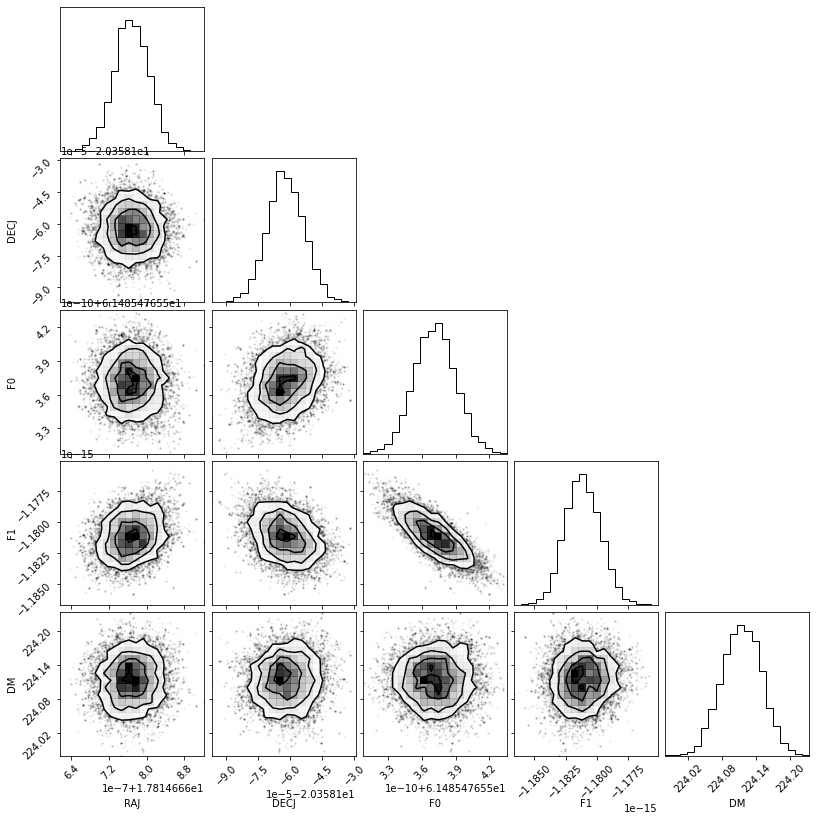

In [25]:
# Plot the posterior distribution.
fig = corner.corner(samples_emcee, labels=bt.param_labels)

## Nested sampling with nestle 

Nested sampling computes the Bayesian evidence along with posterior samples. This allows us to do compare two models. Let us compare the model above with and without an EFAC.

In [7]:
# Let us run the model without EFAC first. We can reuse the `bt` object from before.

# Nesle is really simple :)
# method='multi' runs the MultiNest algorithm.
# `npoints` is the number of live points.
# `dlogz` is the target accuracy in the computed Bayesian evidence.
# Increasing `npoints` or decreasing `dlogz` this gives more accurate results, but slows down the sampling.
result_nestle_1 = nestle.sample(
    bt.lnlikelihood,
    bt.prior_transform,
    bt.nparams,
    method="multi",
    npoints=150,
    dlogz=0.5,
    callback=nestle.print_progress,
)

it=  1699 logz=617.450049

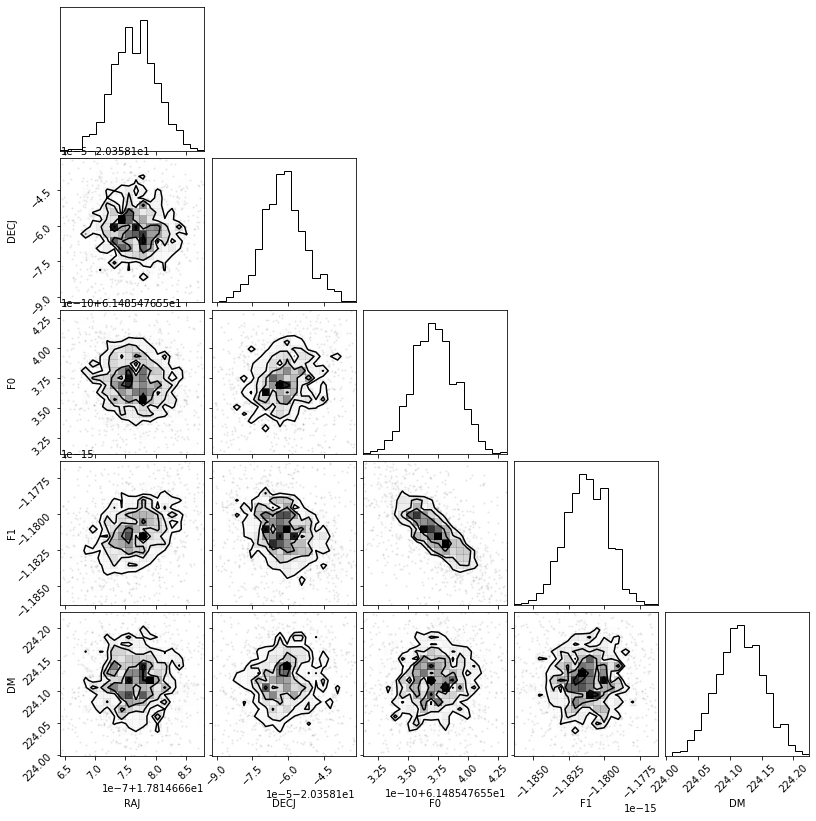

In [10]:
# Plot the posterior
# The nested samples come with weights, which must be taken into account while plotting.
fig = corner.corner(
    result_nestle_1.samples,
    weights=result_nestle_1.weights,
    labels=bt.param_labels,
    range=[0.999] * bt.nparams,
)

Let us create a new model with an EFAC applied to all toas (all TOAs in this dataset are from GBT).

In [11]:
parfile = str(model)  # casting the model to str gives the par file representation.
parfile += "EFAC TEL gbt 1 1"  # Add an EFAC to the par file and make it unfrozen.
model2 = get_model(io.StringIO(parfile))

In [13]:
# Now set the priors.
for par in model2.free_params:
    param = getattr(model2, par)
    param_min = float(param.value - 10 * param.uncertainty_value)
    param_span = float(20 * param.uncertainty_value)
    param.prior = Prior(uniform(param_min, param_span))

model2.EFAC1.prior = Prior(uniform(0.1, 1.9))

In [14]:
bt2 = BayesianTiming(model2, toas, use_pulse_numbers=True)
print(bt2.likelihood_method)

wls


In [15]:
result_nestle_2 = nestle.sample(
    bt2.lnlikelihood,
    bt2.prior_transform,
    bt2.nparams,
    method="multi",
    npoints=150,
    dlogz=0.5,
    callback=nestle.print_progress,
)

2022-07-27 13:03:04.920 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:97 - Creating and dealing with the single TZR_toa for absolute phase
2022-07-27 13:03:04.926 | DEBUG    | pint.toa:__init__:1316 - No pulse number flags found in the TOAs
2022-07-27 13:03:04.927 | DEBUG    | pint.toa:apply_clock_corrections:2095 - Applying clock corrections (include_gps = True, include_bipm = True)
2022-07-27 13:03:04.929 | INFO     | pint.observatory.topo_obs:clock_corrections:296 - Applying observatory clock corrections.
2022-07-27 13:03:04.930 | INFO     | pint.observatory.topo_obs:clock_corrections:301 - Applying GPS to UTC clock correction (~few nanoseconds)
2022-07-27 13:03:04.932 | INFO     | pint.observatory.topo_obs:clock_corrections:306 - Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
2022-07-27 13:03:04.937 | DEBUG    | pint.toa:compute_TDBs:2145 - Computing TDB columns.
2022-07-27 13:03:04.938 | DEBUG    | pint.toa:compute_TDBs:2170 - Using EPHEM = DE421 for TDB calculat

it=  2030 logz=615.378823322

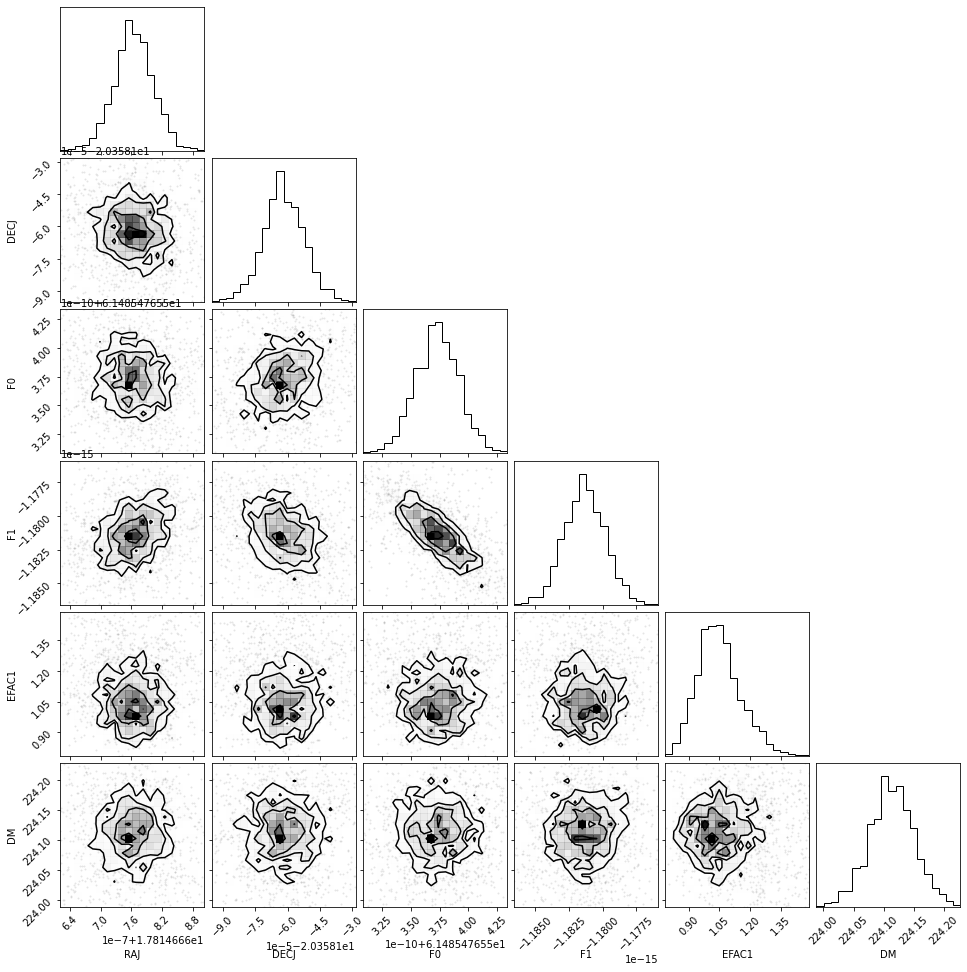

In [18]:
# Plot the posterior.
# The EFAC looks consistent with 1.
fig2 = corner.corner(
    result_nestle_2.samples,
    weights=result_nestle_2.weights,
    labels=bt2.param_labels,
    range=[0.999] * bt2.nparams,
)

Now let us look at the evidences and compute the Bayes factor.

In [22]:
print(f"Evidence without EFAC : {result_nestle_1.logz} +/- {result_nestle_1.logzerr}")
print(f"Evidence with EFAC : {result_nestle_2.logz} +/- {result_nestle_2.logzerr}")

bf = np.exp(result_nestle_1.logz - result_nestle_2.logz)
print(f"Bayes factor : {bf} (in favor of no EFAC)")

Evidence without EFAC : 617.742141790535 +/- 0.23585404001654753
Evidence with EFAC : 615.6010446355048 +/- 0.2545434034322346
Bayes factor : 8.508767947101804 (in favor of no EFAC)


The Bayes factor tells us that the EFAC is unncessary for this dataset.